In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [10]:
import requests
url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json'
r = requests.get(url, allow_redirects=True)

open('sarcasm.json', 'wb').write(r.content)

5643545

In [12]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [13]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [18]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 1s - loss: 0.6658 - accuracy: 0.5854 - val_loss: 0.5904 - val_accuracy: 0.8079
Epoch 2/30
625/625 - 1s - loss: 0.4390 - accuracy: 0.8312 - val_loss: 0.3895 - val_accuracy: 0.8395
Epoch 3/30
625/625 - 1s - loss: 0.3166 - accuracy: 0.8764 - val_loss: 0.3552 - val_accuracy: 0.8521
Epoch 4/30
625/625 - 1s - loss: 0.2653 - accuracy: 0.8982 - val_loss: 0.3445 - val_accuracy: 0.8559
Epoch 5/30
625/625 - 1s - loss: 0.2294 - accuracy: 0.9129 - val_loss: 0.3461 - val_accuracy: 0.8514
Epoch 6/30
625/625 - 1s - loss: 0.2018 - accuracy: 0.9240 - val_loss: 0.3538 - val_accuracy: 0.8492
Epoch 7/30
625/625 - 1s - loss: 0.1790 - accuracy: 0.9337 - val_loss: 0.3594 - val_accuracy: 0.8532
Epoch 8/30
625/625 - 1s - loss: 0.1613 - accuracy: 0.9409 - val_loss: 0.3765 - val_accuracy: 0.8499
Epoch 9/30
625/625 - 1s - loss: 0.1457 - accuracy: 0.9473 - val_loss: 0.3861 - val_accuracy: 0.8512
Epoch 10/30
625/625 - 1s - loss: 0.1340 - accuracy: 0.9520 - val_loss: 0.4149 - val_accuracy: 0.8468

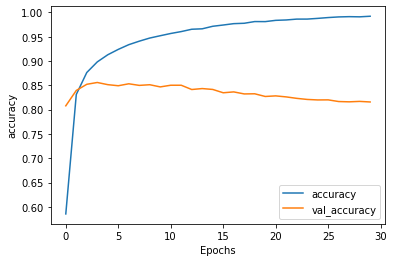

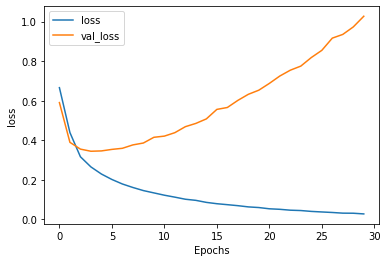

In [19]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [21]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [22]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night","Ofcourse you are so Intelligent","I'm good at Saracasm"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[8.3953130e-01]
 [8.5948395e-06]
 [1.1921227e-03]
 [4.3703822e-06]]


This First output is about 0.91 which is close to 1, indicating the sentences is somewhat sarcastic , similarly all the other sentences have been scored accordingly from 0 - 1.